In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import time
import geopy.distance
from geopy.geocoders import Nominatim
import geocoder 

In [2]:
df = pd.read_csv('data/country_houses.csv')
print(df.shape)
df.head()


(3052, 53)


,Unnamed: 0,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2921238,['Дача'],"['4.3', 'сотки']","['29.6', 'м²']",NaN,['1'],['1994'],NaN,['Дерево'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3152945,['Дача'],"['7', 'соток']","['10', 'м²']",NaN,['1'],['1995'],NaN,['Блочный'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(f"Duplicates found: {df[df.duplicated].shape[0]}")

df = df.drop_duplicates().drop('Unnamed: 0', axis=1)
df.shape

Duplicates found: 0


(3052, 52)

In [4]:
df.columns


Index(['index', 'Тип объекта', 'Площадь участка', 'Площадь общая',
       'Площадь жилая', 'Уровней в доме', 'Год постройки',
       'Процент готовности', 'Материал стен', 'Материал крыши', 'Отопление',
       'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 'Условия продажи',
       'Номер договора', 'Область', 'Район', 'Населенный пункт', 'Номер дома',
       'Сельсовет', 'Координаты', 'Цена', 'Площадь кухни', 'Газ', 'Баня',
       'Гараж', 'Статус земли', 'Сад', 'Хозпостройки', 'Возможен торг',
       'Рядом лес', 'Водоем', 'Ландшафтный дизайн', 'Улица',
       'Ширина застройки', 'Длина застройки', 'Теплица', 'Мебель',
       'Направление', 'Ремонт', 'Камин', 'Строительные материалы',
       'Район города', 'Беседка', 'Микрорайон', 'Новостройка', 'Бассейн',
       'Элитный коттедж', 'Пруд на участке', 'Аукцион'],
      dtype='object')

In [5]:
df['land_area'] = df['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
df['house_area'] = df['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
df['house_levels'] = df['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
df['house_year'] = df['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
df['house_readiness'] = df['Процент готовности'].apply(lambda x: int(re.findall(r"\d{2,}", x)[0]) if x is not np.nan else x)
df['latitude'] = df['Координаты'].apply(lambda x: float(re.findall(r"\d{2}\.\d{2,}", x)[0]) if x is not np.nan else x)
df['longitude'] = df['Координаты'].apply(lambda x: float(re.findall(r"\d{2}\.\d{2,}", x)[1]) if x is not np.nan else x)
df['price'] = df['Цена'].apply(lambda x: float(x.split()[0] + x.split()[1]) if x is not np.nan else x)
df['liv_house_area'] = df['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
df['kitchen_area'] = df['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
df['house_width'] = df['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
df['house_length'] = df['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)

In [6]:
print(f"nan in price column: {df['price'].isna().sum()}")
df = df[df['price'].notna()]
df.shape

nan in price column: 109


(2943, 64)

In [7]:
#thresh = drop_data.shape[0]*0.7
#rop_data = drop_data.dropna(thresh=thresh, axis=1)
#rop_data = drop_data.dropna(how='any', axis=0)

In [8]:
df = df.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки', 'Тип объекта', 'Номер договора', 'Возможен торг', 
              'Номер дома', 'Условия продажи'], axis=1)

df = df[~(df['latitude'].isna())]
df.head()

,index,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,...,house_levels,house_year,house_readiness,latitude,longitude,price,liv_house_area,kitchen_area,house_width,house_length
0,3289189,['Дерево'],['Шифер'],['Печное'],['Местная'],['Есть'],['Скважина'],['Есть'],"['Гомельская', 'область']","['Гомельский', 'район']",...,1.0,2000.0,100.0,52.330913,30.814533,9114.0,12.0,NaN,NaN,NaN
1,3045903,"['Блок', 'газосиликатный']",NaN,['Печное'],['Местная'],['Есть'],['Скважина'],NaN,"['Брестская', 'область']","['Брестский', 'район']",...,2.0,1991.0,NaN,52.010669,23.717579,83003.0,43.1,7.2,NaN,NaN
2,3292051,"['Красный', 'кирпич']",['Шифер'],['Печное'],NaN,['Есть'],NaN,NaN,"['Минская', 'область']","['Молодечненский', 'район']",...,3.0,NaN,100.0,54.389141,26.682371,41990.0,60.0,10.0,NaN,NaN
3,2921238,['Дерево'],['Шифер'],NaN,NaN,['Есть'],NaN,NaN,"['Брестская', 'область']","['Брестский', 'район']",...,1.0,1994.0,NaN,52.071528,23.786624,56963.0,NaN,NaN,NaN,NaN
4,3152945,['Блочный'],NaN,NaN,NaN,NaN,NaN,NaN,"['Гродненская', 'область']","['Гродненский', 'район']",...,1.0,1995.0,NaN,53.620568,23.984891,35805.0,NaN,NaN,NaN,NaN


In [9]:
cat_features = ['Материал стен', 'Отопление', 'Вода', 'Область', 'Район',
       'Населенный пункт', 'Сельсовет', 'Электроснабжение', 'Баня',
       'Материал крыши', 'Канализация', 'Статус земли', 'Камин', 'Гараж', 'Направление', 'Мебель', 'Газ',
       'Ремонт', 'Телефон', 'Новостройка', 'Улица', 'Аукцион', 'Район города','index', 'Водоем', 'Ландшафтный дизайн', 'Пруд на участке', 'Рядом лес',
       'Сад', 'Теплица', 'Хозпостройки', 'Беседка', 'Строительные материалы',
       'Бассейн', 'Элитный коттедж', 'Микрорайон', 'house_levels',
       'house_year']
num_features = ['land_area', 'house_area','house_readiness', 'latitude', 'longitude', 'price',
       'liv_house_area', 'kitchen_area', 'house_width', 'house_length']


In [10]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

index                     2940
Населенный пункт          1566
Сельсовет                  340
Направление                323
Улица                      217
Район                       91
house_year                  74
Материал стен               19
Микрорайон                  18
Материал крыши              13
Вода                        10
Отопление                   10
Район города                 8
Область                      6
Канализация                  5
Электроснабжение             5
Ремонт                       5
Статус земли                 4
house_levels                 4
Газ                          3
Телефон                      2
Бассейн                      1
Сад                          1
Элитный коттедж              1
Строительные материалы       1
Беседка                      1
Хозпостройки                 1
Теплица                      1
Баня                         1
Рядом лес                    1
Пруд на участке              1
Ландшафтный дизайн           1
Водоем  

### Binary categories

In [11]:
bin_categories = categories[categories<=2]  
print(bin_categories)

Телефон                   2
Бассейн                   1
Сад                       1
Элитный коттедж           1
Строительные материалы    1
Беседка                   1
Хозпостройки              1
Теплица                   1
Баня                      1
Рядом лес                 1
Пруд на участке           1
Ландшафтный дизайн        1
Водоем                    1
Аукцион                   1
Мебель                    1
Гараж                     1
Камин                     1
Новостройка               1
dtype: int64


In [12]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    345
Name: count, dtype: int64

Камин
['Да']    331
Name: count, dtype: int64

Телефон
['Есть']             83
['2', 'телефона']     1
Name: count, dtype: int64

In [13]:
# let's handle nan in binary categories
bin_categories = categories[categories<=2]   

for item in bin_categories.index:
    df[item] = df[item].apply(lambda x: 0 if pd.isna(x) else 1)

In [14]:
def draw_categories(features, ax_width=10, tick_rotation=30):
    n = len(features) 
    fig, axes = plt.subplots(n, 2, figsize=(ax_width, n*3)) 

    for i, feature in enumerate(features):
        #print(n,i,feature)
        count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
        sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0], width=0.4).set(title=f'{feature} (ratio)', xlabel='');
        axes[i][0].xaxis.set_tick_params(rotation=tick_rotation)
        sns.barplot(df, x=feature, y='price', ax=axes[i][1], width=0.4).set(title=f'{feature} (price)', xlabel='');
        axes[i][1].xaxis.set_tick_params(rotation=tick_rotation)
    plt.tight_layout() 
    

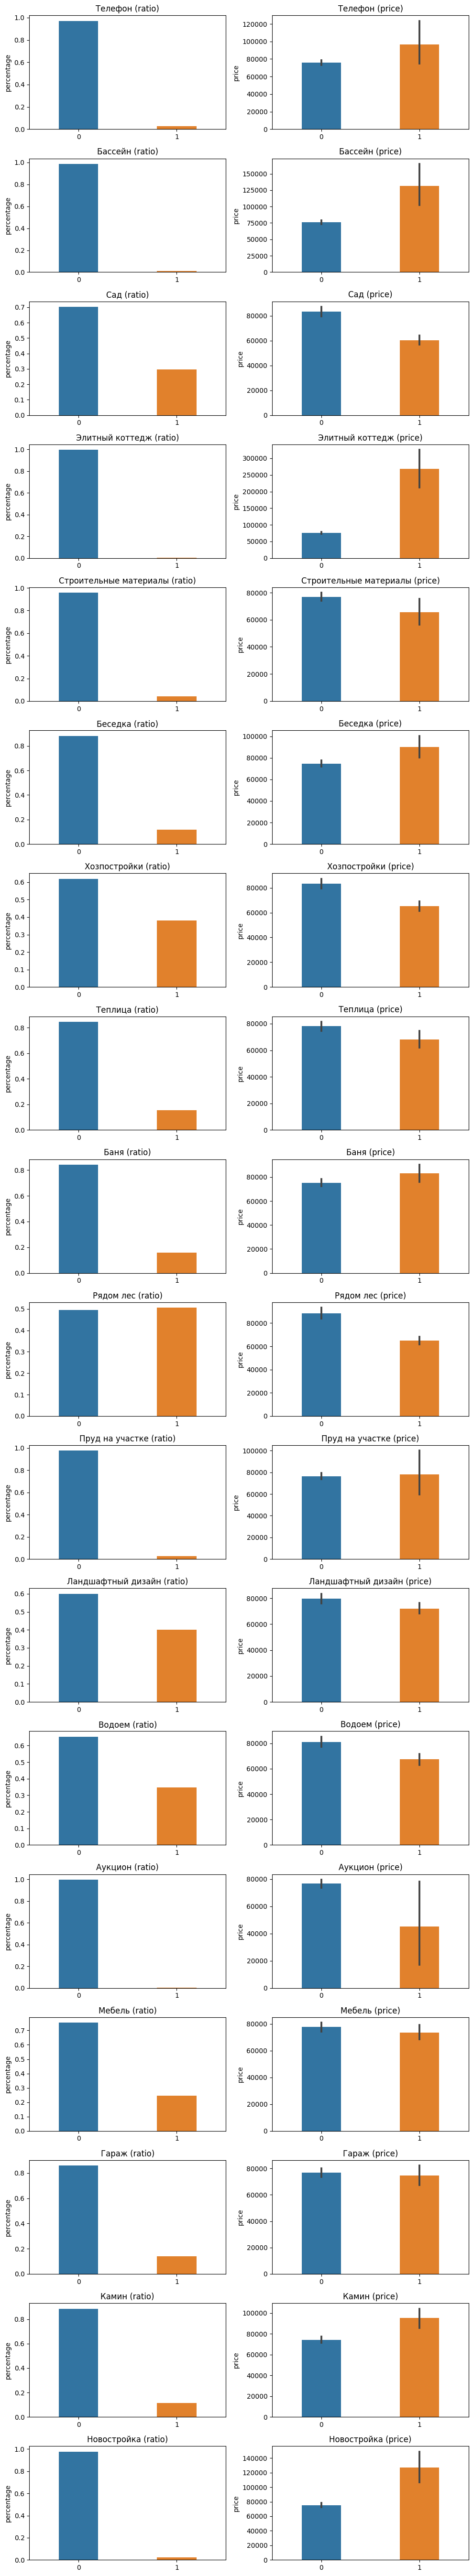

In [15]:
draw_categories(bin_categories.index, tick_rotation=0)

In [16]:
df = df.drop(['Аукцион'], axis=1)

### Multi options categories 

In [17]:
multi_categories = categories[categories>2]
display(multi_categories)


index               2940
Населенный пункт    1566
Сельсовет            340
Направление          323
Улица                217
Район                 91
house_year            74
Материал стен         19
Микрорайон            18
Материал крыши        13
Вода                  10
Отопление             10
Район города           8
Область                6
Канализация            5
Электроснабжение       5
Ремонт                 5
Статус земли           4
house_levels           4
Газ                    3
dtype: int64

In [18]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Микрорайон          2868
Район города        2819
Улица               2609
Ремонт              2380
Направление         1937
Газ                 1338
Канализация          965
house_year           865
Сельсовет            833
Отопление            719
Материал крыши       691
house_levels         577
Вода                 403
Электроснабжение     384
Статус земли         372
Материал стен        344
Район                  5
Область                0
Населенный пункт       0
index                  0
dtype: int64

In [19]:
df = df.drop(['Микрорайон', 'Район города', 'Улица', 'index'], axis=1)

In [20]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ', 'Ремонт']
fill_na_mode = ['Материал крыши', 'house_levels', 'house_year', 'Статус земли', 'Материал стен']
fill_na_find = ['Направление', 'Сельсовет', 'Район']


In [21]:
df['Газ'] = df['Газ'].map({
    "['Рядом']":'рядом', 
    "['Есть']":'есть', 
    "['Нет']":'нет', 
    })

In [22]:
df['Канализация'] = df['Канализация'].map({
    "['С/у', 'на', 'улице']":'с/у снаружи', 
    "['Местная']":'местная', 
    "['Есть']":'местная', 
    "['Центральная']":'центральн', 
    "['Нет']":'нет',
    })

In [23]:
df['Электроснабжение'] = df['Электроснабжение'].map({
    "['Есть']":'220В', 
    "['220В']":'220В', 
    "['Рядом']":'рядом', 
    "['380В']":'380В', 
    "['Нет']":'нет',
    })

In [24]:
df['Отопление'] = df['Отопление'].map({
    "['Печное']":'печь', 
    "['Нет']":'нет', 
    "['На', 'газу']":'паровое г.', 
    "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
    "['Электрическое']":'электрич.',
    "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
    "['Паровое']":'паровое т.',
    "['Альтернативные', 'источники']":'альтерн.',
    "['Центральное']":'центральн.',
    "['Паровое', 'на', 'газу']":'паровое г.',
    })

In [25]:
df['Вода'] = df['Вода'].map({
    "['Сезонная']":'сезонная', 
    "['Скважина']":'скважина', 
    "['Колодец']":'колодец', 
    "['Центральный', 'водопровод']":'центральн.',
    "['Холодная']":'холодная',
    "['Рядом', 'колодец']":'рядом',
    "['Рядом']":'рядом',
    "['Горячая']":'горячая',
    "['Нет']":'нет',
    "['Рядом', 'водопровод']":'рядом'})

In [26]:
df['Ремонт'] = df['Ремонт'].map({
    "['Отделка', 'деревом']":'отделка дер.', 
    "['Не', 'достроен']":'не достроен',
    "['Евроотделка']":'евроотделка',
    "['Евроотделка,', 'отделка', 'деревом']":'евроотделка дер.',
    "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен'})

In [27]:
df[fill_na_net] = df[fill_na_net].fillna('нет')

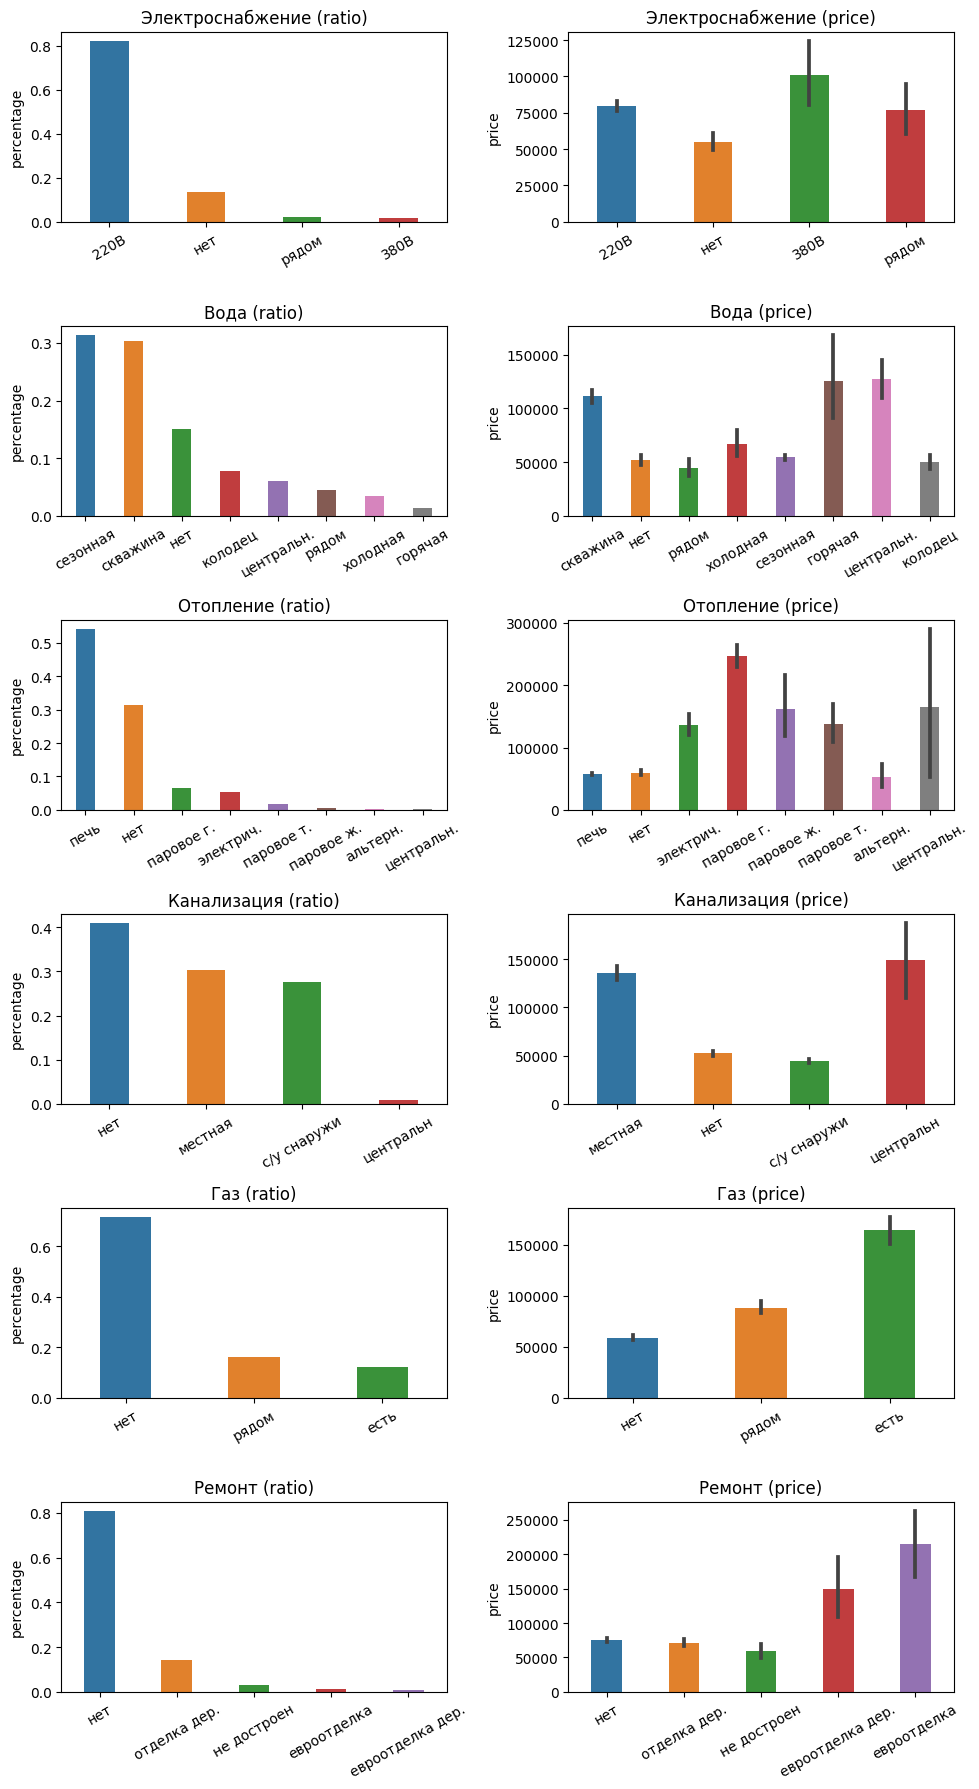

In [28]:
draw_categories(fill_na_net)

In [29]:
fill_na_mode

['Материал крыши',
 'house_levels',
 'house_year',
 'Статус земли',
 'Материал стен']

In [30]:
fea = 'Материал стен'
display(df[fea].value_counts())
print(f"nan values: {df[fea].isna().sum()}")

Материал стен
['Дерево']                             667
['Кирпичный']                          556
['Блок', 'газосиликатный']             398
['Блочный']                            261
['Сборно-щитовой']                     162
['Сруб']                               139
['Дерево,', 'обложено', 'кирпичом']    119
['Белый', 'кирпич']                     67
['Каркасный', 'деревянный']             59
['Брус', 'профилированный']             53
['Каркасно-засыпной']                   35
['Красный', 'кирпич']                   17
['Брус', 'оцилиндрованный']             15
['Облицовочный', 'кирпич']              12
['Панельный']                           11
['Керамзитбетон']                       10
['Шлакобетон']                           9
['Брус', 'клееный']                      4
['Монолитно-каркасный']                  2
Name: count, dtype: int64

nan values: 344


In [31]:
df['Материал стен'] = df['Материал стен'].map({
    "['Дерево']":'дерево', 
    "['Кирпичный']":'кирпич', 
    "['Блок', 'газосиликатный']":'блок г/с', 
    "['Блочный']":'блок',
    "['Сборно-щитовой']":'сб-щитовой',
    "['Сруб']":'сруб',
    "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
    "['Белый', 'кирпич']":'кирпич бел.',
    "['Каркасный', 'деревянный']":'каркасн. дер.',
    "['Брус', 'профилированный']":'брус профил.',
    "['Каркасно-засыпной']":'каркасн. засыпн. ',
    "['Брус', 'оцилиндрованный']":'брус оцил.',
    "['Красный', 'кирпич']":'кирпич красн.',
    "['Облицовочный', 'кирпич']":'кирпич облиц.',
    "['Панельный']":'панельн.',
    "['Керамзитбетон']":'керамзитобетон',
    "['Шлакобетон']":'шлакобетон',
    "['Брус', 'клееный']":'брус клеен.',
    "['Монолитно-каркасный']":'каркасн. монол.'})

In [32]:
df['Материал крыши'] = df['Материал крыши'].map({
    "['Шифер']":'шифер', 
    "['Металло-черепица']":'черепица мет.', 
    "['Ондулин']":'ондулин', 
    "['Металл']":'металл',
    "['Евро-шифер']":'е-шифер',
    "['Мягкая', 'черепица']":'черепица мяг.',
    "['Черепица']":'черепица',
    "['Битумная', 'черепица']":'черепица бит.',
    "['Жесть']":'жесть',
    "['Рубероид']":'рубероид',
    "['Гидроизоляция']":'гидроизоляция',
    "['Доски']":'доски',
    "['Природные', 'материалы']":'природн.'})

In [33]:
fea = 'Статус земли'
display(df[fea].value_counts())
print(f"nan values: {df[fea].isna().sum()}")

Статус земли
['Частная']                                   2204
['Пожизненноe', 'наследуемое', 'владение']     316
['Другое']                                      24
['Аренда']                                      24
Name: count, dtype: int64

nan values: 372


In [34]:
df['Статус земли'] = df['Статус земли'].map({
    "['Частная']":'частная', 
    "['Пожизненноe', 'наследуемое', 'владение']":'пожизн.', 
    "['Другое']":'частная', 
    "['Аренда']":'аренда',
})

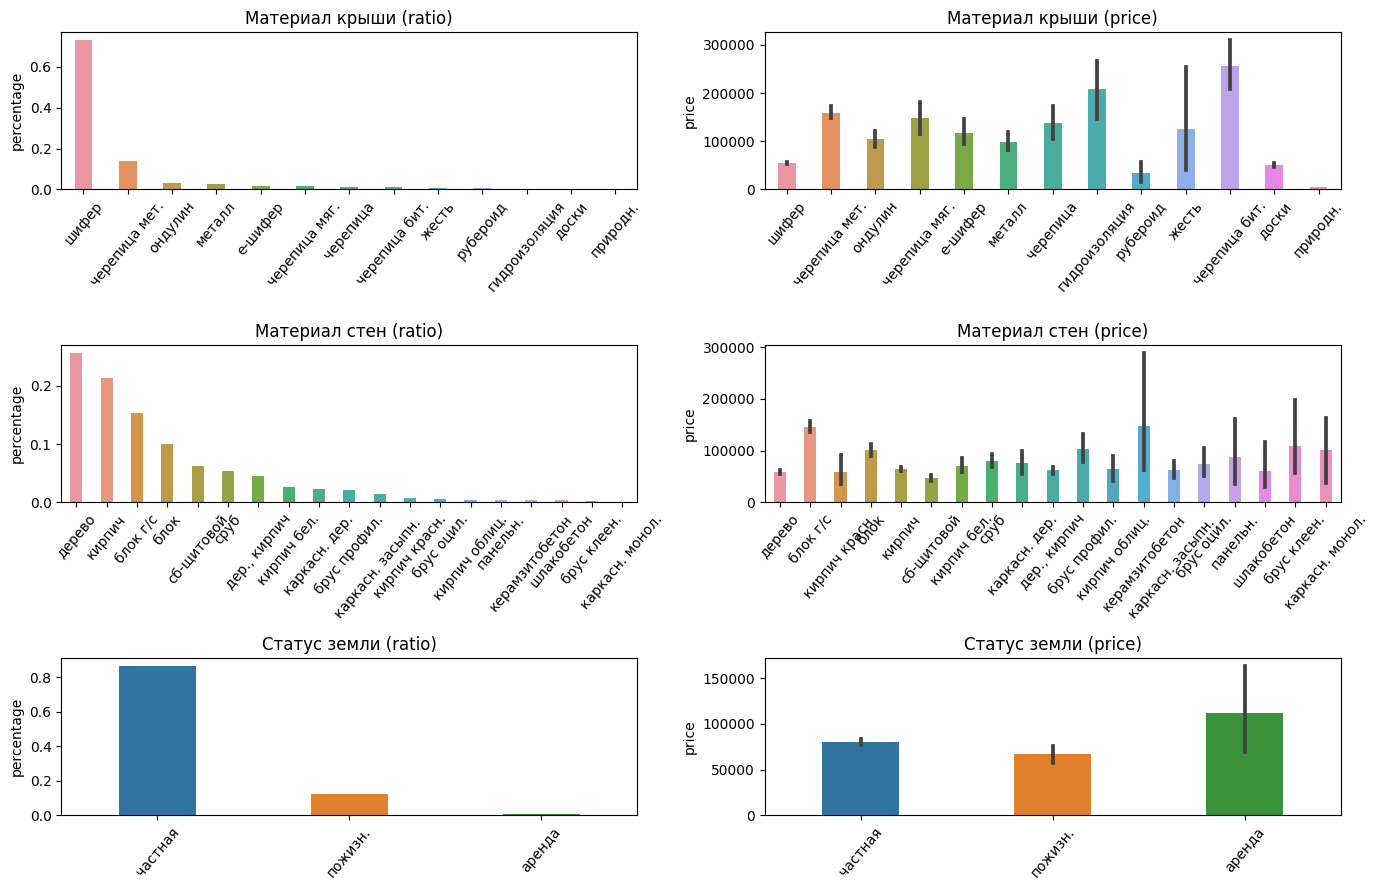

In [35]:
draw_categories(['Материал крыши', 'Материал стен', 'Статус земли'], 14, 50)

In [36]:
fea = 'house_year'
display(df[fea].value_counts())
print(f"nan values: {df[fea].isna().sum()}")

house_year
1990.0    127
1995.0     98
2023.0     85
2000.0     80
1998.0     71
         ... 
1961.0      1
1945.0      1
1976.0      1
1916.0      1
1946.0      1
Name: count, Length: 74, dtype: int64

nan values: 865


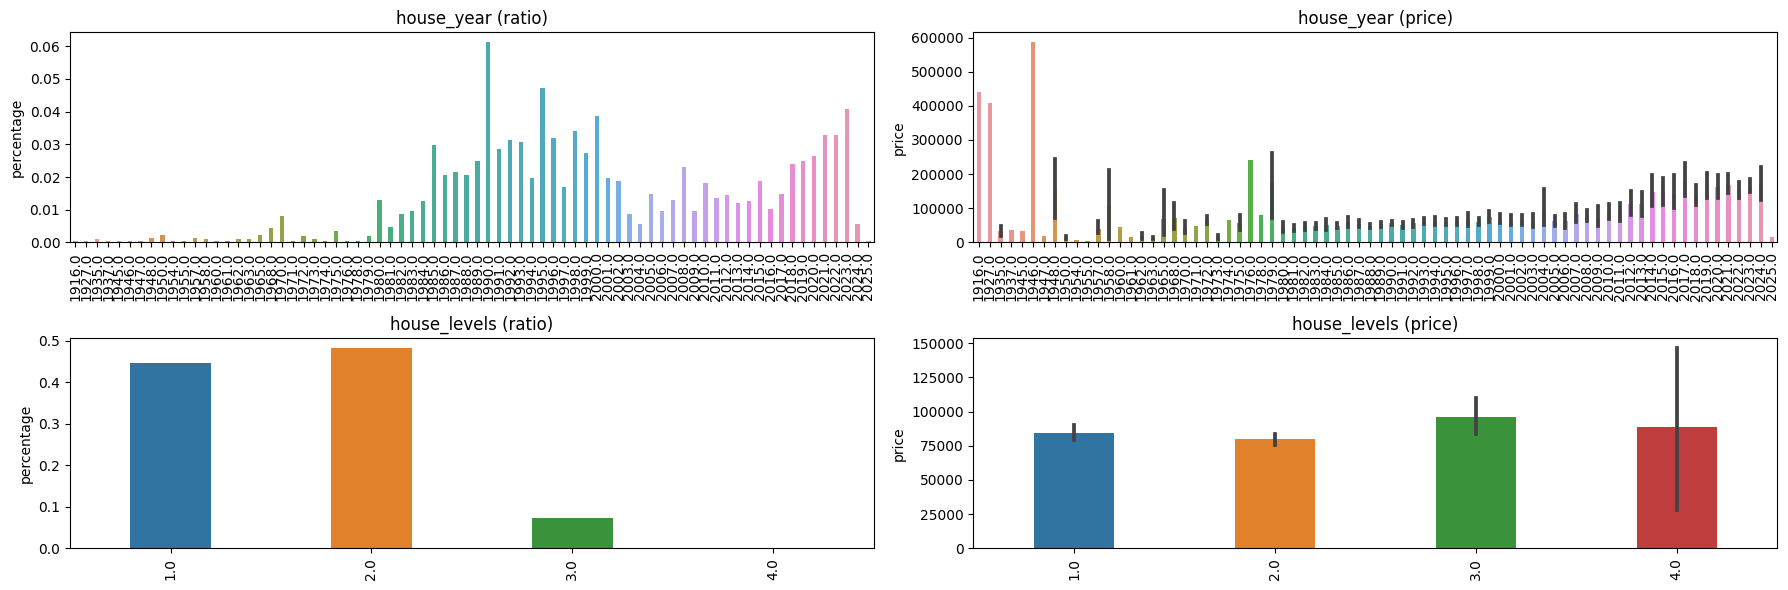

In [37]:
draw_categories(['house_year','house_levels'], 18, 90)

In [38]:
minsk_inx = df[df['Населенный пункт']=="['г.', 'Минск']"].index
df.loc[minsk_inx,'Район'] = 'г.Минск'

df['Район'] = df['Район'].fillna(df.groupby('Населенный пункт')['Район'].transform(lambda x: x.mode()[0]))

# df["value"] = df.groupby("name").transform(lambda x: x.fillna(x.mean()))
# df['value'] = df['value'].fillna(df.groupby('name')['value'].transform('mean'))


In [39]:
temp = df['house_year'].isna()
inds = temp[temp==True].index

print(f"nan in 'house_year': {df['house_year'].isna().sum()}")
df['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
print(f"nan after filling with city mode: {df['house_year'].isna().sum()}")
#df['year'] = df['year'].fillna(df.groupby('Район')['year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
#print(f"nan after filling with district mode: {df['year'].isna().sum()}")
df['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
print(f"nan after filling with df mode: {df['house_year'].isna().sum()}")

df.loc[inds[30:40], ['Населенный пункт','house_year']]

nan in 'house_year': 865
nan after filling with city mode: 422
nan after filling with df mode: 0


,Населенный пункт,house_year
136,"['с/т', 'Луговцы']",1992.0
139,"['г.', 'Витебск']",1970.0
146,"['г.', 'Новополоцк']",1996.0
149,"['аг.', 'Головчицы']",1990.0
154,"['с/т', 'Обувщик-5']",1990.0
160,"['с/т', 'Смородинка']",1991.0
170,"['д.', 'Колубели']",1990.0
171,"['д.', 'Каменица-Жировецкая']",2023.0
175,"['д.', 'Крути']",1990.0
181,"['с/т', 'Черница']",1990.0


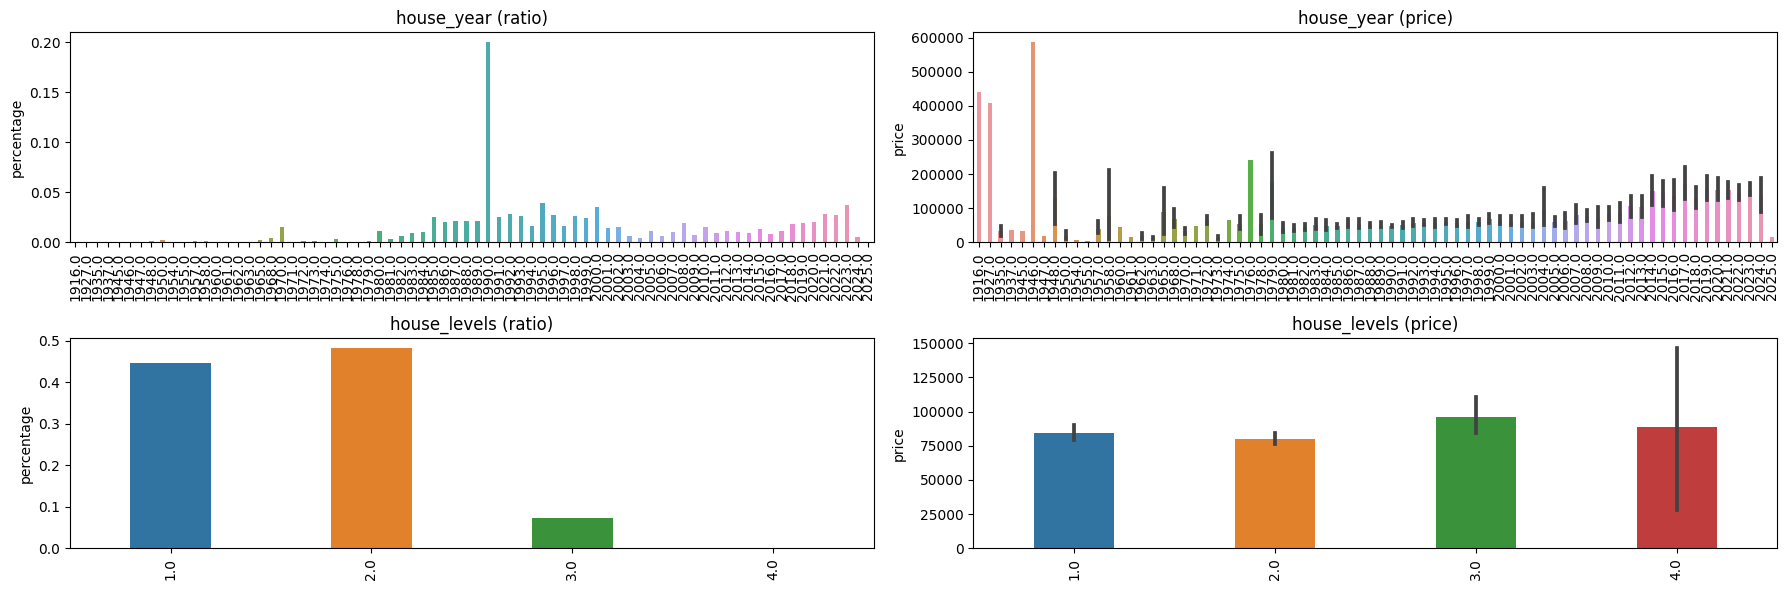

In [40]:
draw_categories(['house_year','house_levels'], 18, 90)

In [41]:
fill_na_find

['Направление', 'Сельсовет', 'Район']

### Направление

In [42]:
display(df['Направление'].value_counts())
df['Направление'].isna().sum()

Направление
['Молодечненское,', '35', 'км', 'от', 'МКАД']      26
['Молодечненское,', '23', 'км', 'от', 'МКАД']      17
['Московское,', '18', 'км', 'от', 'МКАД']          15
['Молодечненское,', '20', 'км', 'от', 'МКАД']      14
['Мядельское,', '11', 'км', 'от', 'МКАД']          14
                                                   ..
['Логойское,', '7', 'км', 'от', 'МКАД']             1
['Пуховичское,', '47', 'км', 'от', 'МКАД']          1
['Московское,', '17.6', 'км', 'от', 'МКАД']         1
['Молодечненское,', '45.8', 'км', 'от', 'МКАД']     1
['Молодечненское,', '36.9', 'км', 'от', 'МКАД']     1
Name: count, Length: 323, dtype: int64

1937

### Область

In [43]:
df['Область'].value_counts()

Область
['Минская', 'область']        1468
['Брестская', 'область']       684
['Гродненская', 'область']     278
['Витебская', 'область']       209
['Гомельская', 'область']      174
['Могилевская', 'область']     127
Name: count, dtype: int64

In [44]:
df['Область'] = df['Область'].map({
    "['Гомельская', 'область']":'Гомель', 
    "['Минская', 'область']":'Минск', 
    "['Гродненская', 'область']":'Гродно', 
    "['Брестская', 'область']":'Брест',
    "['Могилевская', 'область']":'Могилев',
    "['Витебская', 'область']":'Витебск',
})

In [45]:
df['Область'].value_counts()

Область
Минск      1468
Брест       684
Гродно      278
Витебск     209
Гомель      174
Могилев     127
Name: count, dtype: int64

In [46]:
def get_location(name):
    try:
        g = geocoder.bing(name, key='AgY4Qy8qL2I1oMf6xu6SSpqncKEFzpjZIKzs3Y_lhKvdA4cRPMUpBEIDmgXxm5_e')
        results = g.json
        #print(name, results['lat'], results['lng'])
        return (results['lat'], results['lng'])
    except:
        print(name)
        return name

regions_dict = dict()
selsovets = df['Область'].unique()
for item in selsovets:
    if type(item) is str:
        regions_dict[item] = get_location(item + ', беларусь')
    else:
        continue

print(regions_dict)

df['regional_center_coordinates'] = df['Область'].apply(lambda x: regions_dict[x] if type(x) is str else x)

{'Гомель': (52.4191246, 30.97227287), 'Брест': (52.0941124, 23.7319088), 'Минск': (53.897686, 27.54942131), 'Гродно': (53.67042542, 23.82331085), 'Могилев': (53.90841293, 30.34563446), 'Витебск': (55.1845932, 30.20467567)}


### Сельсовет

In [47]:
def tryconvert(value):
    try:
        res = re.findall(r'\'(\w+)\'',value.replace('-',''))
        return res[0]
    except:
        return value
    
#df['Область'] = df['Область'].apply(lambda x: tryconvert(x))

df['Сельсовет'] = df['Сельсовет'].apply(lambda x: tryconvert(x))


In [48]:
fea = 'Сельсовет'
display(df[fea].value_counts())
print(f"nan values: {df[fea].isna().sum()}")

Сельсовет
Мухавецкий      107
Коптёвский       70
Раковский        65
Папернянский     56
Ждановичский     53
               ... 
Узовский          1
Лиозненский       1
Еремичский        1
Друевский         1
Ясенский          1
Name: count, Length: 340, dtype: int64

nan values: 833


In [49]:
df['Сельсовет'] = df['Сельсовет'].fillna(df.groupby('Населенный пункт')['Сельсовет'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
print(f"nan values: {df[fea].isna().sum()}")

nan values: 457


### Район

In [50]:
df['Район'] = df['Район'].apply(lambda x: tryconvert(x))

df['Район'].value_counts().index

Index(['Брестский', 'Минский', 'Гродненский', 'Смолевичский', 'Пуховичский',
       'Молодечненский', 'Дзержинский', 'Витебский', 'Логойский',
       'Воложинский', 'Гомельский', 'Борисовский', 'Солигорский',
       'Могилевский', 'Столбцовский', 'Полоцкий', 'Узденский', 'Бобруйский',
       'Лидский', 'Сморгонский', 'Добрушский', 'Речицкий', 'Оршанский',
       'Червенский', 'Осиповичский', 'Барановичский', 'Слуцкий', 'Шкловский',
       'Крупский', 'Пинский', 'Браславский', 'Березинский', 'Жабинковский',
       'Малоритский', 'Мядельский', 'Каменецкий', 'Мозырский', 'Чаусский',
       'Кобринский', 'Кировский', 'Рогачевский', 'Вилейский', 'Волковысский',
       'Ляховичский', 'Глубокский', 'Лепельский', 'БудаКошелевский',
       'Слонимский', 'Быховский', 'Жлобинский', 'Белыничский', 'Ветковский',
       'Несвижский', 'Городокский', 'Кореличский', 'Любанский', 'Копыльский',
       'Ганцевичский', 'г.Минск', 'Светлогорский', 'Лиозненский',
       'Костюковичский', 'Березовский', 'Росс

In [52]:
from ipynb.fs.full.parsing_2 import get_district_details

district_dict = dict()

for i in df['Район'].unique():
    try:
        district_dict[i] = get_district_details(i)
    except:
        print(i, "couldn't get data")
        continue


Гомельский ['52.2527', '31.0048']
Брестский ['52.0655', '23.3940']
Молодечненский ['54.1849', '26.5106']
Гродненский ['53.4000', '23.4900']
Бобруйский ['53.0600', '29.1300']
Речицкий ['52.2150', '30.2341']
Докшицкий ['54.5300', '27.4600']
Логойский ['54.12', '27.51']
Минский ['53.5400', '27.3400']
Воложинский ['54.0500', '26.3100']
Смолевичский ['54.0122', '28.0419']
Пуховичский ['53.3100', '28.0830']
Дзержинский ['53.4100', '27.0800']
Витебский ['55.1100', '30.1000']
Кобринский ['52.1246', '24.2218']
Шкловский ['54.1230', '30.1713']
Жабинковский ['52.1206', '24.0118']
Узденский ['53.2758', '27.1328']
Борисовский ['54.1400', '28.3000']
Чаусский ['53.4800', '30.5800']
Лидский ['53.5314', '25.1810']
Малоритский ['51.4736', '24.0413']
г.Минск couldn't get data
Крупский ['54.1930', '29.0810']
Вилейский ['54.2900', '26.5500']
Добрушский ['52.2500', '31.1900']
Ляховичский ['53.0220', '26.1559']
Пинский ['52.0730', '26.0509']
Столбцовский ['53.2900', '26.4400']
Полоцкий ['55.28', '28.48']
Орш

In [54]:
df['district_center_coordinates'] = df['Район'].apply(lambda x: district_dict[x] if x in district_dict else district_dict['Минский'])

In [55]:
df.loc[200:230, ['Район','Область','district_center_coordinates','regional_center_coordinates']]

,Район,Область,district_center_coordinates,regional_center_coordinates
200,Минский,Минск,"[53.5400, 27.3400]","(53.897686, 27.54942131)"
201,Пуховичский,Минск,"[53.3100, 28.0830]","(53.897686, 27.54942131)"
202,Молодечненский,Минск,"[54.1849, 26.5106]","(53.897686, 27.54942131)"
203,Борисовский,Минск,"[54.1400, 28.3000]","(53.897686, 27.54942131)"
204,Барановичский,Брест,"[53.0740, 25.5843]","(52.0941124, 23.7319088)"
205,Полоцкий,Витебск,"[55.28, 28.48]","(55.1845932, 30.20467567)"
206,Столбцовский,Минск,"[53.2900, 26.4400]","(53.897686, 27.54942131)"
207,Брестский,Брест,"[52.0655, 23.3940]","(52.0941124, 23.7319088)"
208,Гродненский,Гродно,"[53.4000, 23.4900]","(53.67042542, 23.82331085)"
209,Молодечненский,Минск,"[54.1849, 26.5106]","(53.897686, 27.54942131)"


In [56]:
df.to_csv('data/country_houses_treated2.csv')

In [57]:
dfc = pd.read_csv('data/country_houses_treated.csv')
dfc.head()

,Unnamed: 0,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,...,house_readiness,latitude,longitude,price,liv_house_area,kitchen_area,house_width,house_length,regional_center_coordinates,district_center_coordinates
0,0,дерево,шифер,печь,местная,220В,скважина,1,Гомель,Гомельский,...,100.0,52.330913,30.814533,9114.0,12.0,NaN,NaN,NaN,"(52.4191246, 30.97227287)","['52.2527', '31.0048']"
1,1,блок г/с,NaN,печь,местная,220В,скважина,0,Брест,Брестский,...,NaN,52.010669,23.717579,83003.0,43.1,7.2,NaN,NaN,"(52.0941124, 23.7319088)","['52.0655', '23.3940']"
2,2,кирпич красн.,шифер,печь,нет,220В,нет,0,Минск,Молодечненский,...,100.0,54.389141,26.682371,41990.0,60.0,10.0,NaN,NaN,"(53.897686, 27.54942131)","['54.1849', '26.5106']"
3,3,дерево,шифер,нет,нет,220В,нет,0,Брест,Брестский,...,NaN,52.071528,23.786624,56963.0,NaN,NaN,NaN,NaN,"(52.0941124, 23.7319088)","['52.0655', '23.3940']"
4,4,блок,NaN,нет,нет,нет,нет,0,Гродно,Гродненский,...,NaN,53.620568,23.984891,35805.0,NaN,NaN,NaN,NaN,"(53.67042542, 23.82331085)","['53.4000', '23.4900']"


In [ ]:

# The Vincenty distance uses more accurate ellipsoidal models,
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print geopy.distance.geodesic(coords_1, coords_2).km

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (1564357564.py, line 5)

In [ ]:
X = df.loc[:,['latitude', 'longitude']]

def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42, n_init='auto')
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.labels_)
    inertia = k_means.inertia_
    return silhouette, inertia

interv = range(2,20)
silhouette = {x:0 for x in interv}
inertia = {x:0 for x in interv}
for num in interv:
    silhouette[num] = (get_silhouette(num, X)[0])
    inertia[num] = (get_silhouette(num, X)[1])

#f,a = plt.subplots(1,2,figsize=(8,5))
#sns.lineplot(x=interv, y=silhouette.values(), ax=a[0]).set(title='silhouette score', xlabel='cluster qty');
#sns.lineplot(x=interv, y=inertia.values(), ax=a[1]).set(title='inertia', xlabel='cluster qty');

k_means =  KMeans(n_clusters=9, random_state=42, n_init='auto')
k_means.fit(X)

df_labels = pd.Series(k_means.labels_)
df['cluster'] = k_means.labels_
#df_labels.value_counts()

#f,a = plt.subplots(figsize=(8,8))
#sns.scatterplot(df, x='latitude', y='longitude', hue='cluster', palette='colorblind', s=10);


color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()